<a href="_index.ipynb">&larr; SMP </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>
# SMP: Abtastung und Downsampling #
## Dezimation / Downsampling von Audiosignalen ##

In diesem Notebook wird die Abtastrate von Audiosignalen reduziert, mit und und ohne vorheriger Filterung. Die Spektren werden in Form von Spektrogrammen dargestellt. 


In [1]:
import os, sys

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

import numpy as np
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange,
                    linspace, array, zeros, ones)
import scipy.signal as sig

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, subplots, title, clf, xlim, ylim)
import wave

from IPython.display import Audio, display

## Auslesen und Abspielen eines wav-Files ##
Diese Zelle demostriert nur, wie man einen wav-File öffnet und abspielt. 

In [3]:

figsize = {"figsize":(14,6)}
np_type = np.int16 # data type for wav file
path = '../medien' # path for wav files
filename = 'ComputerBeeps2.wav'
filename = 'SpaceRipple.wav'
#filename = '92002__jcveliz__violin-origional.wav'
filename = "4914__noisecollector__cat2.wav"

wf = wave.open(os.path.join(path, filename),'rb')
N_CHAN   = wf.getnchannels()# number of channels
W_SAMP   = wf.getsampwidth()# wordlength of samples
N_FRAMES = wf.getnframes()  # number of frames = len(samples) // n_chan
rate_in  = wf.getframerate()# sample (frame) rate 
STEREO = N_CHAN == 2

samples_in = np.frombuffer(wf.readframes(-1), dtype=np_type) # wav data as 16 bit integers in interleaved channels
samples = np.array([samples_in[idx::N_CHAN] for idx in range(N_CHAN)]) # deinterleave channels to numpy array N_CHAN x N_FRAMES

wf.close() # wav data has been copied to numpy array, close file now.

print("Channels:\t{0}\nSample width:\t{1} bytes\nOutput rate:\t{2} Hz\nInput Samples:\t{3}"\
      .format(N_CHAN, W_SAMP, rate_in, N_FRAMES))

display(Audio(data=samples, rate=rate_in))

Channels:	2
Sample width:	2 bytes
Output rate:	44100 Hz
Input Samples:	44627


## Spektrogramm ##
Der Soundschnipsel wird als Spekrogramm angezeigt d.h. als Serie von FFTs über der Zeit. Der Betrag der FFT wird über die Farbe angezeigt. Die Länge der FFT pro "Scheibchen" bestimmt den Komromiss zwischen Zeit- und Frequenzauflösung. Die Fensterungsfunktion für die Daten bestimmt den Kompromiss zwischen Amplitudengenauigkeit, Leckeffekt und Frequenzauflösung.

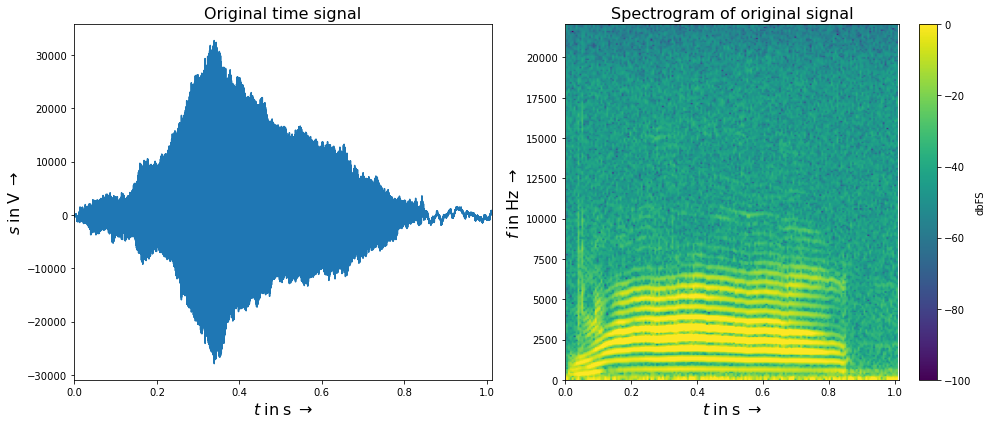

In [4]:
NFFT = 512 # DFT length of spectrograms
dbmin = -100; dbmax = 0 # Limits for log. display
win = sig.windows.kaiser(NFFT,12, sym = False) # needs NFFT and shape parameter beta
#win = sig.hann(NFFT)
fig1, ax = subplots(nrows=1, ncols=2, **figsize)
ax[0].plot(arange(len(samples[0]))/rate_in, samples[0])
ax[0].set_xlim([0, N_FRAMES/rate_in])
ax[0].set_xlabel(r'$t \; \mathrm{in \; s}\;\rightarrow$', fontsize = 16)
ax[0].set_ylabel(r'$s \; \mathrm{in \; V}\;\rightarrow$', fontsize = 16)
ax[0].set_title('Original time signal',fontsize = 16)
Pxx, freqs, bins, im = ax[1].specgram(samples[0] / NFFT, NFFT=NFFT, Fs=rate_in, 
                            noverlap=NFFT/2, mode = 'magnitude', window = win, 
                            scale = 'dB', vmin = dbmin, vmax = dbmax)
plt.colorbar(im, label="dbFS")
ax[1].set_xlabel(r'$t \; \mathrm{in \; s}\;\rightarrow$', fontsize = 16)
ax[1].set_ylabel(r'$f \; \mathrm{in \; Hz}\;\rightarrow$', fontsize = 16)
ax[1].set_title('Spectrogram of original signal', fontsize = 16)
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim([0, rate_in/2])
plt.tight_layout()

## Downsampling und Dezimation  ##
Zum Reduzieren der Datenrate kann man einfach jedes R-te Sample der ursprünglichen Daten hernehmen, das nennt man **Downsampling**. Genau wie beim analogen Abtasten besteht das Risiko, dass Spektralkomponenten des ursprünglichen Signals außerhalb des neuen Basisbands liegen und heruntergefaltet werden (Aliasing).

Filtert man das Signal vorher, nennt man den Prozess **Dezimation**. Dem Befehl `decimate()` aus der `scipy.signal` kann man neben dem Dezimationsfaktor $R$ auch den Filtertyp mitgeben: Beim Filtertyp 'fir' wird standardmäßig ein Filter der Länge 30 mit Hamming Fenster verwendet, beim Filtertyp 'iir' ein Chebychev I Filter der Ordnung 8.

In [12]:
R = 8# downsampling ratio - must be power of 2
FILTER = True  # if TRUE: use filter before downsampling

n_samp_out = int(np.ceil(N_FRAMES / R))
rate_out = rate_in // R
print("Output rate:\t{0} Hz\nOutput samples:\t{1}".format(rate_out, n_samp_out))

# initialize array for decimated / downsampled samples for speed-up
samples_out = zeros((N_CHAN, n_samp_out), dtype=np_type) 

if FILTER:
    # apply decimation filter before downsampling by  a factor of R
    samples_out = sig.decimate(samples, R, ftype='fir')
else:
    # downsample by R by picking every Rth sample without prior filtering
    samples_out = samples.T[::R].T # transpose, take every R'th frame, transpose back to original orientation

display(Audio(data=samples_out, rate=rate_out))

Output rate:	5512 Hz
Output samples:	5579


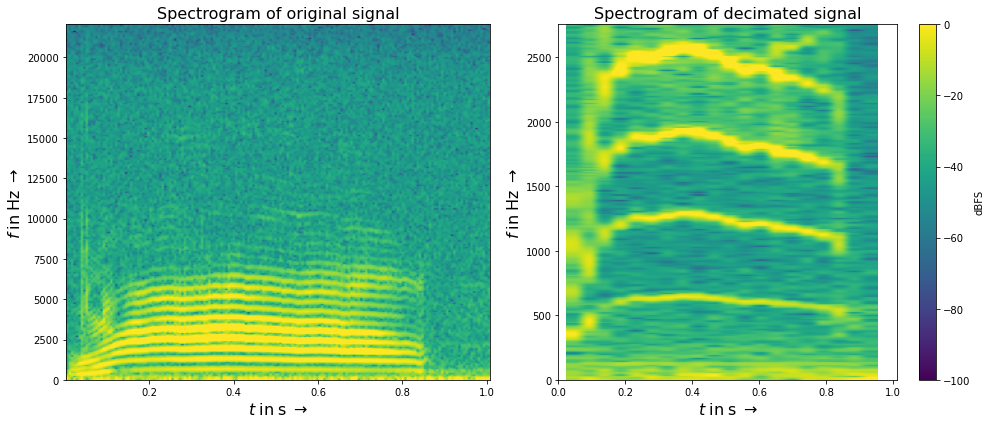

In [13]:
dbmin = -100; dbmax = 0 # Limits for log. display
fig2, ax = subplots(nrows=1, ncols=2, **figsize)
Pxx, freqs, bins, im = ax[0].specgram(samples[0] / NFFT, NFFT=NFFT, Fs=rate_in, 
                            noverlap=NFFT/2, mode = 'magnitude', window = win, 
                            scale = 'dB', vmin = dbmin, vmax = dbmax)
ax[0].set_xlabel(r'$t \; \mathrm{in \; s}\;\rightarrow$', fontsize = 16)
ax[0].set_ylabel(r'$f \; \mathrm{in \; Hz}\;\rightarrow$', fontsize = 16)
ax[0].set_title('Spectrogram of original signal', fontsize = 16)
ax[0].set_xlim(ax[0].get_xlim())
ax[0].set_ylim([0, rate_in/2])

Pxx, freqs, bins, im2 = ax[1].specgram(samples_out[0] / NFFT, NFFT=NFFT, Fs=rate_out, 
                            noverlap=NFFT/2, mode = 'magnitude', window = win, 
                            scale = 'dB', vmin = dbmin, vmax = dbmax)
ax[1].set_xlabel(r'$t \; \mathrm{in \; s}\;\rightarrow$', fontsize = 16)
ax[1].set_ylabel(r'$f \; \mathrm{in \; Hz}\;\rightarrow$', fontsize = 16)
if FILTER:
    ax[1].set_title('Spectrogram of decimated signal', fontsize = 16)
else:
    ax[1].set_title('Spectrogram of downsampled signal', fontsize = 16)        
ax[1].set_xlim([0, n_samp_out/rate_out])
ax[1].set_ylim([0, rate_out/2])
plt.colorbar(im2, label = "dBFS")
plt.tight_layout()

## Fragen und Experimente ##

- Ändern Sie die Abtastrate mit und ohne Filterung (FILTER=False) und hören bzw. sehen Sie sich die Unterschiede an.
- Ändern Sie die FFT Länge für das Spektrogramm. Welche Zeit- bzw. Frequenzauflösung erhalten Sie jeweils?
- Überlagern Sie einen Sinus-Sweep den Audiosignalen

***
### Copyright

(c) 2016 - 2020 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.